In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session, Query
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
conn = engine.connect()

In [6]:
# reflect an existing database into a new model
Base = automap_base()
Base.prepare(engine,reflect=True)

# reflect the tables

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [10]:
inspector = inspect(engine)
inspector.get_columns('measurement')

[{'name': 'id',
  'type': INTEGER(),
  'nullable': False,
  'default': None,
  'autoincrement': 'auto',
  'primary_key': 1},
 {'name': 'station',
  'type': TEXT(),
  'nullable': True,
  'default': None,
  'autoincrement': 'auto',
  'primary_key': 0},
 {'name': 'date',
  'type': TEXT(),
  'nullable': True,
  'default': None,
  'autoincrement': 'auto',
  'primary_key': 0},
 {'name': 'prcp',
  'type': FLOAT(),
  'nullable': True,
  'default': None,
  'autoincrement': 'auto',
  'primary_key': 0},
 {'name': 'tobs',
  'type': FLOAT(),
  'nullable': True,
  'default': None,
  'autoincrement': 'auto',
  'primary_key': 0}]

# Exploratory Climate Analysis

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
first_date = dt.datetime.strptime((Query(measurement)
.with_session(session)
.order_by(measurement.date.desc())
.first().date
),"%Y-%m-%d")


# Calculate the date 1 year ago from the last data point in the database
year_before = first_date - dt.timedelta(days= 365)
# Perform a query to retrieve the data and precipitation scores
l_twelve = (Query(measurement)
.with_session(session)
#.with_entities(measurement.get_columns())
.group_by(measurement.date,measurement.station,measurement.prcp)
.filter(measurement.date > year_before)
.order_by(measurement.date.asc())
.all()
)
# Save the query results as a Pandas DataFrame and set the index to the date column

#prcp_anly = pd.DataFrame(l_twelve)
# Sort the dataframe by date

#prcp_anly

# Use Pandas Plotting with Matplotlib to plot the data

#prcp_anly['station'].unique()
results = engine.execute(f"SELECT * from measurement WHERE date > {year_before.date()};")
temp_df = pd.DataFrame(results).pivot(index = 2,columns = 1,values = 3)
last_year = temp_df[temp_df.index > dt.datetime.strftime(year_before,"%Y-%m-%d")]
last_year

1,USC00511918,USC00513117,USC00514830,USC00516128,USC00517948,USC00518838,USC00519281,USC00519397,USC00519523
2,,,,,,,,,
2016-08-24,NaN,2.15,2.28,1.45,NaN,NaN,2.15,0.08,1.22
2016-08-25,NaN,0.08,0.00,0.11,0.00,NaN,0.06,0.08,0.21
2016-08-26,NaN,0.03,0.02,NaN,0.04,NaN,0.01,0.00,0.00
2016-08-27,NaN,0.18,0.02,NaN,NaN,NaN,0.12,0.00,0.00
2016-08-28,NaN,0.14,0.14,2.07,NaN,NaN,0.60,0.01,0.14
...,...,...,...,...,...,...,...,...,...
2017-08-19,NaN,NaN,0.00,0.09,NaN,NaN,NaN,0.00,NaN
2017-08-20,NaN,NaN,0.01,NaN,NaN,NaN,NaN,0.00,NaN
2017-08-21,NaN,NaN,0.02,0.56,NaN,NaN,NaN,0.00,NaN


In [12]:
# for station in last_year.columns:
#     print()
#     fig, ax = plt.subplots(figsize = (5,5))
#     ax.plot(last_year.index,last_year[f'{station}'])


In [13]:
# Use Pandas to calcualte the summary statistics for the precipitation data
lasT_year_stats = last_year.describe()

In [14]:
# Design a query to show how many stations are available in this dataset?
q = engine.execute("SELECT COUNT(DISTINCT station) FROM measurement;")
[_[0] for _ in q]

[9]

In [15]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
most_active_list = session.query(measurement.station,func.count(measurement.station)).group_by(measurement.station).order_by(func.count(measurement.station).desc()).all()
most_active = most_active_list[0][0]
most_active

'USC00519281'

In [16]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
session.query(measurement.station,func.min(measurement.tobs),func.max(measurement.tobs),func.avg(measurement.tobs)).\
filter(measurement.station == most_active).all()

[('USC00519281', 54.0, 85.0, 71.66378066378067)]

(array([ 6., 10., 15., 27., 41., 58., 72., 85., 29.,  8.]),
 array([59. , 61.4, 63.8, 66.2, 68.6, 71. , 73.4, 75.8, 78.2, 80.6, 83. ]),
 <a list of 10 Patch objects>)

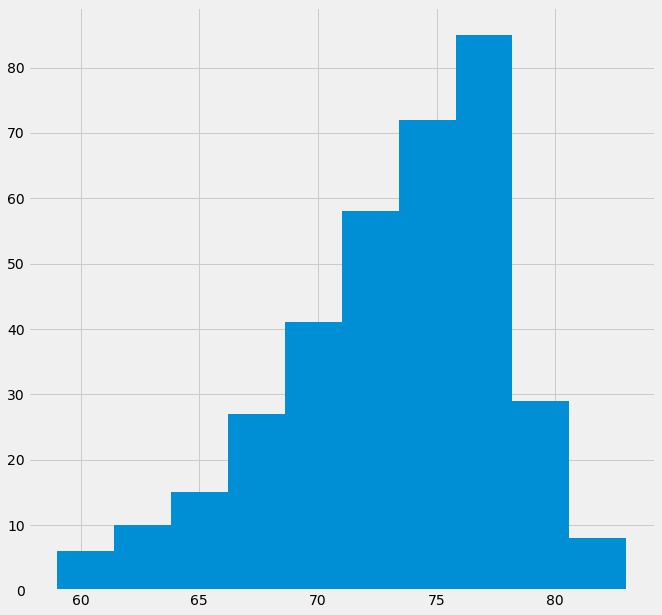

In [17]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

temp_obvs = session.query(measurement.tobs).filter(measurement.date > year_before,measurement.station == most_active).all()

heat_list = [x[0] for x in temp_obvs]
fig1, ax1 = plt.subplots(figsize = (10,10))
ax1.hist(heat_list)

## Bonus Challenge Assignment

In [18]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

NameError: name 'Measurement' is not defined

In [ ]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
